# FEATURE SELECTION & CROSS-VALIDATION

- 05/18/21
- onl01-dtsc-ft-022221

## Learning Objectives

- To discuss the 3 general types of feature selection methods and give examples of each. 
- To discuss the ideal use of GridSearch/cross-validation in our modeling process. 
- To learn how to save and load models.

### Resources/References

- [Udemy Course: Feature Selection for Machine Learning Models](https://www.udemy.com/course/feature-selection-for-machine-learning/) - inspired much of today's content. 
- [Tamjid's Blog Post: "Beginners guide for feature selection"](https://tamjida.medium.com/beginners-guide-for-feature-selection-by-a-beginner-cd2158c5c36a)

### Notebook Headers for Study Group

- **⭐️Feature Selection Study Group⭐️**
- ⭐️**Cross Validation**⭐️
- ⭐️**Saving Models**⭐️

___

# Predicting Parkinon's Disease from Speech

## INTRODUCTION

- Parkinson's Disease is a neurological disorder that affects coordination, balance, walking, and can also affect speech.
    - [NIA - Parkinson's Disease]( https://www.nia.nih.gov/health/parkinsons-disease#:~:text=Parkinson's%20disease%20is%20a%20brain,have%20difficulty%20walking%20and%20talking)
    
    -[Parkinson's Foundation](https://www.parkinson.org/Understanding-Parkinsons/Symptoms/Non-Movement-Symptoms/Speech-and-Swallowing-Problems)
    
- This dataset was created during the publication for > "A comparative analysis of speech signal processing algorithms for Parkinson’s disease classification and the use of the tunable Q-factor wavelet transform" 
    - https://doi.org/10.1016/j.asoc.2018.10.022

## OBTAIN

- The dataset was downloaded from https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification. 
>- "Abstract: The data used in this study were gathered from 188 patients with PD (107 men and 81 women) with ages ranging from 33 to 87 (65.1Â±10.9).
    - Data Source: 

- [Related paper](https://www.sciencedirect.com/science/article/abs/pii/S1568494618305799?via%3Dihub)
    - PDF located inside `reference` folder.
    - See Table 1 on page 9.
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn import metrics

## Models & Utils
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time

In [2]:
# ## Changing Pandas Options to see full columns in previews and info
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
pd.set_option('display.float_format',lambda x: f"{x:.2f}")

In [3]:
# Modeling Functions
%load_ext autoreload
%autoreload 2

# import project_functions as pf
import study_group_functions as pf

In [4]:
df = pd.read_csv('pd_speech_features.csv',skiprows=1)
df

id  gender  PPE  DFA  RPDE  numPulses  numPeriodsPulses  \
0      0       1 0.85 0.72  0.57        240               239   
1      0       1 0.77 0.69  0.54        234               233   
2      0       1 0.85 0.68  0.59        232               231   
3      1       0 0.41 0.80  0.59        178               177   
4      1       0 0.33 0.80  0.53        236               235   
..   ...     ...  ...  ...   ...        ...               ...   
751  250       0 0.81 0.56  0.28        417               416   
752  250       0 0.16 0.56  0.59        415               413   
753  251       0 0.88 0.72  0.47        381               380   
754  251       0 0.84 0.75  0.50        340               339   
755  251       0 0.81 0.76  0.46        340               339   

     meanPeriodPulses  stdDevPeriodPulses  locPctJitter  locAbsJitter  \
0                0.01                0.00          0.00          0.00   
1                0.01                0.00          0.00          0.00   
2                0.01                0.00          0.00          0.00   
3                0.01                0.00          0.00          0.00   
4                0.01                0.00          0.01          0.00   
..                ...                 ...           ...           ...   
751              0.00                0.00          0.00          0.00   
752              0.00                0.00          0.00          0.00   
753              0.01                0.00          0.00          0.00   
754              0.01                0.00          0.00          0.00   
755              0.01                0.00          0.00          0.00   

     rapJitter  ppq5Jitter  ddpJitter  locShimmer  locDbShimmer  apq3Shimmer  \
0         0.00        0.00       0.00        0.06          0.52         0.03   
1         0.00        0.00       0.00        0.06          0.50         0.02   
2         0.00        0.00       0.00        0.10          0.90         0.05   
3         0.00        0.00       0.00        0.05          0.53         0.02   
4         0.00        0.00       0.00        0.06          0.50         0.03   
..         ...         ...        ...         ...           ...          ...   
751       0.00        0.00       0.00        0.02          0.17         0.01   
752       0.00        0.00       0.00        0.04          0.48         0.02   
753       0.00        0.00       0.00        0.03          0.26         0.02   
754       0.00        0.00       0.00        0.04          0.31         0.02   
755       0.00        0.00       0.00        0.04          0.33         0.02   

     apq5Shimmer  apq11Shimmer  ddaShimmer  meanAutoCorrHarmonicity  \
0           0.03          0.05        0.09                     0.97   
1           0.04          0.06        0.07                     0.98   
2           0.06          0.08        0.15                     0.97   
3           0.03          0.04        0.07                     0.97   
4           0.03          0.05        0.09                     0.98   
..           ...           ...         ...                      ...   
751         0.01          0.02        0.03                     1.00   
752         0.03          0.03        0.07                     0.98   
753         0.02          0.02        0.05                     1.00   
754         0.02          0.03        0.05                     0.99   
755         0.02          0.03        0.06                     1.00   

     meanNoiseToHarmHarmonicity  meanHarmToNoiseHarmonicity  minIntensity  \
0                          0.04                       19.00         70.00   
1                          0.02                       21.50         67.42   
2                          0.03                       17.65         62.66   
3                          0.04                       19.86         76.31   
4                          0.03                       19.56         76.65   
..                          ...                         ...           ..

## SCRUB

In [5]:
## null value check
nulls= df.isna().sum()
nulls.sum()

0

In [6]:
## Preview columns and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 755 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              756 non-null    int64  
 1   gender                          756 non-null    int64  
 2   PPE                             756 non-null    float64
 3   DFA                             756 non-null    float64
 4   RPDE                            756 non-null    float64
 5   numPulses                       756 non-null    int64  
 6   numPeriodsPulses                756 non-null    int64  
 7   meanPeriodPulses                756 non-null    float64
 8   stdDevPeriodPulses              756 non-null    float64
 9   locPctJitter                    756 non-null    float64
 10  locAbsJitter                    756 non-null    float64
 11  rapJitter                       756 non-null    float64
 12  ppq5Jitter                      756

## EXPLORE

> - Too many features to visualize at once. Working on a workflow in the appendix to visualzie related columns, but still work in progress.

(754, 754)


<AxesSubplot:>

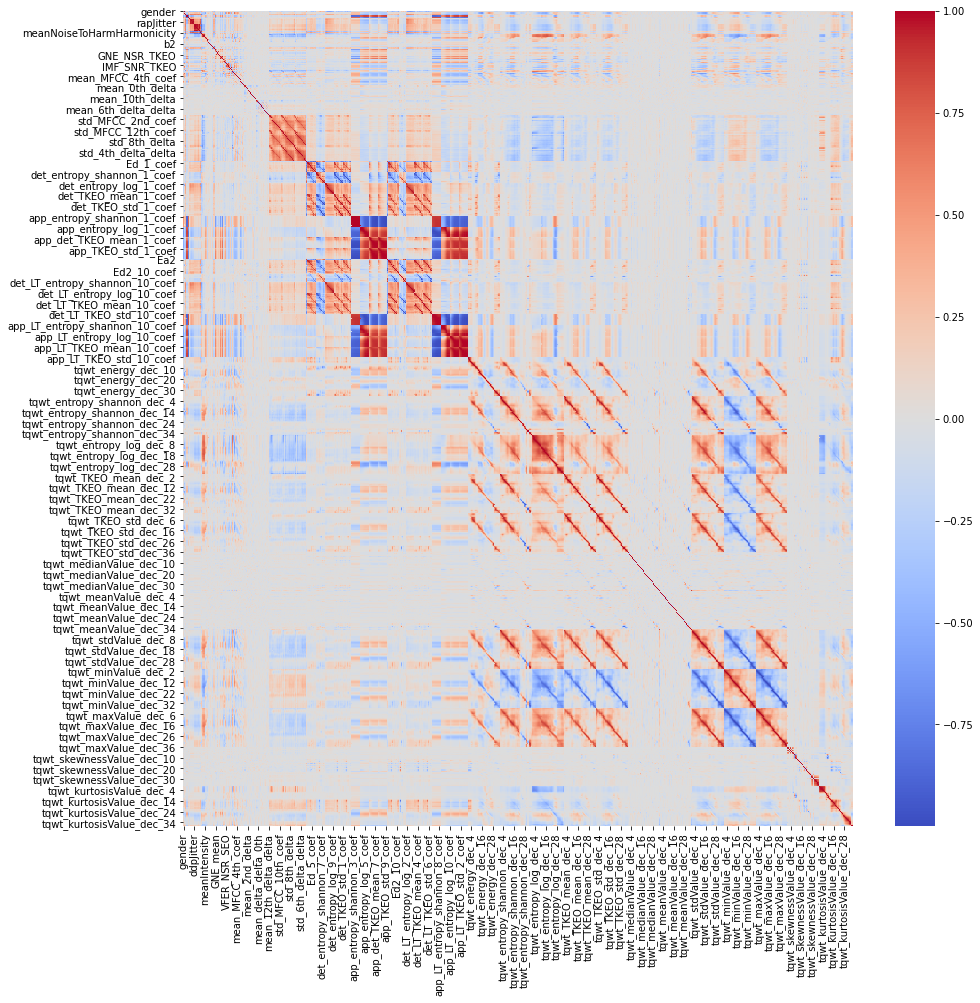

In [7]:
corr = df.drop('id',axis=1).corr()
print(corr.shape)
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm')

#### Features

- In order to preprocess this dataset, I should identify related features based on their names and create a dictionary to be able to slice out all related columns for EDA. [Appendix'd for now]


- Features include results of vairous speech signal processing algorithms including (see Table 1 below):
    - Time Frequency Features
    - Mel Frequency Cepstral Coefficients (MFCCs)
    - Wavelet Transform based Features, 
    - Vocal Fold Features 
    - and TWQT features 

- Remaining Feature Questions

    - [ ] Which cols are "Fundamenal frequency parameters"?
    
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-phase-3-project/main/reference/table_1.png" width=80%>



#### Finding Categorical Features

In [8]:
## Seeing which columns may be categorical
df.nunique()[(df.nunique() < 20)]

gender    2
class     2
dtype: int64

In [9]:
## making gender a str so its caught by pipeline
df['gender'] = df['gender'].astype(str)

## PREPROCESSING 

### Train/Test Split

In [10]:
## Specifying root names of types of features to loop through and filter out from df
target_col = 'class'
drop_cols = ['id']

y = df[target_col].copy()
X = df.drop(columns=[target_col,*drop_cols]).copy()
y.value_counts(1)

1   0.75
0   0.25
Name: class, dtype: float64

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train

gender  PPE  DFA  RPDE  numPulses  numPeriodsPulses  meanPeriodPulses  \
626      1 0.83 0.72  0.44        333               332              0.01   
110      1 0.84 0.62  0.53        310               309              0.01   
421      0 0.17 0.80  0.48        291               290              0.01   
285      1 0.86 0.72  0.67        337               336              0.01   
460      1 0.78 0.72  0.61        224               223              0.01   
..     ...  ...  ...   ...        ...               ...               ...   
297      1 0.84 0.66  0.41        339               338              0.01   
503      1 0.85 0.72  0.46        250               249              0.01   
445      0 0.76 0.70  0.48        337               336              0.01   
513      0 0.75 0.73  0.44        343               342              0.01   
220      1 0.82 0.64  0.42        265               264              0.01   

     stdDevPeriodPulses  locPctJitter  locAbsJitter  rapJitter  ppq5Jitter  \
626                0.00          0.00          0.00       0.00        0.00   
110                0.00          0.00          0.00       0.00        0.00   
421                0.00          0.00          0.00       0.00        0.00   
285                0.00          0.00          0.00       0.00        0.00   
460                0.00          0.00          0.00       0.00        0.00   
..                  ...           ...           ...        ...         ...   
297                0.00          0.00          0.00       0.00        0.00   
503                0.00          0.00          0.00       0.00        0.00   
445                0.00          0.00          0.00       0.00        0.00   
513                0.00          0.00          0.00       0.00        0.00   
220                0.00          0.01          0.00       0.00        0.00   

     ddpJitter  locShimmer  locDbShimmer  apq3Shimmer  apq5Shimmer  \
626       0.00        0.08          0.72         0.05         0.05   
110       0.00        0.06          0.50         0.03         0.03   
421       0.00        0.05          0.47         0.03         0.03   
285       0.00        0.14          1.23         0.08         0.09   
460       0.00        0.03          0.25         0.01         0.02   
..         ...         ...           ...          ...          ...   
297       0.00        0.03          0.24         0.01         0.02   
503       0.00        0.05          0.46         0.03         0.03   
445       0.00        0.05          0.42         0.02         0.02   
513       0.00        0.10          0.92         0.05         0.06   
220       0.01        0.05          0.41         0.03         0.02   

     apq11Shimmer  ddaShimmer  meanAutoCorrHarmonicity  \
626          0.05        0.14                     0.96   
110          0.05        0.09                     0.98   
421          0.04        0.09                     0.98   
285          0.10        0.23                     0.87   
460          0.03        0.04                     0.98   
..            ...         ...                      ...   
297          0.02        0.04                     0.98   
503          0.04        0.09                     0.98   
445          0.03        0.07                     0.99   
513          0.09        0.14                     0.98   
220          0.03        0.08                     0.99   

     meanNoiseToHarmHarmonicity  meanHarmToNoiseHarmonicity  minIntensity  \
626                        0.05                       15.90         77.23   
110                        0.02                       17.21         75.45   
421                        0.03                       16.75         75.41   
285                        0.15                        8.83         60.05   
460                        0.03                       22.32         76.35   
..                          ...                         ...           ...   
297                        0.02                       16.81      

In [12]:
from sklearn import set_config
set_config(display='diagram')

In [13]:
## saving list of numeric vs categorical feature
num_cols = list(X_train.select_dtypes('number').columns)
cat_cols = list(X_train.select_dtypes('object').columns)

## create pipelines and column transformer
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scale',MinMaxScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('encoder',OneHotEncoder(sparse=False,drop='first'))])

print('# of num_cols:',len(num_cols))
print('# of cat_cols:',len(cat_cols))

## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
preprocessor=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])

preprocessor

# of num_cols: 752
# of cat_cols: 1


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', MinMaxScaler())]),
                                 ['PPE', 'DFA', 'RPDE', 'numPulses',
                                  'numPeriodsPulses', 'meanPeriodPulses',
                                  'stdDevPeriodPulses', 'locPctJitter',
                                  'locAbsJitter', 'rapJitter', 'ppq5Jitter',
                                  'ddpJitter', 'locShimmer', 'locDbShimmer',
                                  'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer',
                                  'ddaShimmer', 'meanAutoCorrHarmonicity',
                                  'meanNoiseToHarmHarmonicity',
                                  'meanHarmToNoiseHarmonicity', 'minIntensity',
                                  'maxIntensity', 'meanIntensity', 'f1', 'f2',
                                  'f3', 'f4', 'b1', 'b2', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 ['gender'])])

In [14]:
## Fit preprocessing pipeline on training data and pull out the feature names and X_cols
preprocessor.fit(X_train)

## Use the encoder's .get_feature_names
cat_features = list(preprocessor.named_transformers_['cat'].named_steps['encoder']\
                            .get_feature_names(cat_cols))
X_cols = num_cols+cat_features

## Transform X_traian,X_test and remake dfs
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index, columns=X_cols)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          index=X_test.index, columns=X_cols)

## Tranform X_train and X_test and make into DataFrames
X_train_df

PPE  DFA  RPDE  numPulses  numPeriodsPulses  meanPeriodPulses  \
626 0.91 0.57  0.40       0.37              0.37              0.37   
110 0.92 0.24  0.53       0.34              0.34              0.41   
421 0.14 0.84  0.46       0.32              0.32              0.45   
285 0.94 0.57  0.72       0.37              0.37              0.36   
460 0.85 0.56  0.64       0.25              0.25              0.65   
..   ...  ...   ...        ...               ...               ...   
297 0.92 0.39  0.35       0.37              0.37              0.36   
503 0.93 0.57  0.42       0.27              0.27              0.56   
445 0.83 0.51  0.46       0.37              0.37              0.36   
513 0.82 0.61  0.40       0.38              0.38              0.35   
220 0.90 0.31  0.37       0.29              0.29              0.52   

     stdDevPeriodPulses  locPctJitter  locAbsJitter  rapJitter  ppq5Jitter  \
626                0.01          0.08          0.05       0.06        0.07   
110                0.01          0.04          0.03       0.02        0.03   
421                0.64          0.13          0.10       0.09        0.10   
285                0.03          0.11          0.07       0.08        0.10   
460                0.03          0.05          0.05       0.03        0.04   
..                  ...           ...           ...        ...         ...   
297                0.01          0.02          0.02       0.01        0.02   
503                0.01          0.03          0.03       0.02        0.03   
445                0.25          0.12          0.08       0.07        0.04   
513                0.01          0.03          0.02       0.02        0.02   
220                0.52          0.27          0.21       0.21        0.09   

     ddpJitter  locShimmer  locDbShimmer  apq3Shimmer  apq5Shimmer  \
626       0.06        0.31          0.32         0.34         0.23   
110       0.02        0.21          0.22         0.22         0.14   
421       0.09        0.19          0.20         0.21         0.13   
285       0.08        0.54          0.57         0.59         0.44   
460       0.03        0.09          0.10         0.08         0.07   
..         ...         ...           ...          ...          ...   
297       0.01        0.09          0.09         0.09         0.07   
503       0.02        0.18          0.19         0.21         0.13   
445       0.07        0.16          0.18         0.16         0.11   
513       0.02        0.38          0.42         0.33         0.27   
220       0.21        0.16          0.17         0.18         0.10   

     apq11Shimmer  ddaShimmer  meanAutoCorrHarmonicity  \
626          0.17        0.34                     0.91   
110          0.18        0.22                     0.95   
421          0.12        0.21                     0.94   
285          0.35        0.59                     0.69   
460          0.09        0.08                     0.94   
..            ...         ...                      ...   
297          0.06        0.09                     0.95   
503          0.12        0.21                     0.96   
445          0.10        0.16                     0.97   
513          0.32        0.33                     0.94   
220          0.09        0.18                     0.97   

     meanNoiseToHarmHarmonicity  meanHarmToNoiseHarmonicity  minIntensity  \
626                        0.06                        0.45          0.87   
110                        0.03                        0.49          0.84   
421                        0.03                        0.48          0.83   
285                        0.19                        0.23          0.54   
460                        0.04                        0.66          0.85   
..                          ...                         ...           ...   
297                        0.03                        0.48          0.86   
503                        0.02                        0.58          0.78

In [15]:
y.value_counts(1)

1   0.75
0   0.25
Name: class, dtype: float64

### Resampling with SMOTENC

In [16]:
y_train.value_counts()

1    421
0    146
Name: class, dtype: int64

In [17]:
## Save list of trues and falses for each cols
smote_feats = [False]*len(num_cols) +[True]*len(cat_features)
# smote_feats

In [18]:
## resample training data
smote = SMOTENC(smote_feats)
X_train_sm,y_train_sm = smote.fit_resample(X_train_df,y_train)
y_train_sm.value_counts()

1    421
0    421
Name: class, dtype: int64

## MODELING

#### Setting `train_test_list`

In [19]:
### SAVING XY DATA TO LIST TO UNPACK
train_test_list = [X_train_sm,y_train_sm,X_test_df,y_test]

## Baseline Model: Linear SVC

[i] Training started at 05/18/21-13:21:11:
	Training time was 0.4435 seconds.

           Train  Test  Difference
accuracy   0.99  0.80        0.18 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.63      0.61        46
           1       0.88      0.86      0.87       143

    accuracy                           0.80       189
   macro avg       0.74      0.75      0.74       189
weighted avg       0.81      0.80      0.81       189



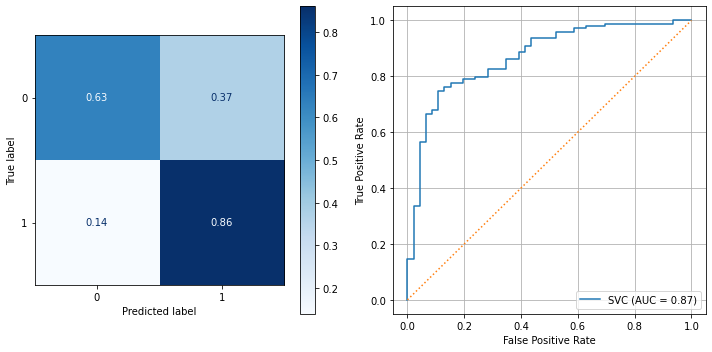

SVC(C=1, kernel='linear')

In [20]:
# Baseline model is a lienar SVC 
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,*train_test_list)

___

# **⭐️Feature Selection Study Group⭐️**

- Office Hours for 022221FT
- 05/18/21

## Types  of Feature Selection

- Filter Methods.
- Wrapper Methods.
- Embedded Methods.
- Hybrid Methods (not discussed here, see resources at top of notebook for details)


### Filter Methods

> Filter methods: rely on the characteristics of the features themselves. Does not involve machine learning models. Ideal for quick screen and removal of irrelevant features.

- Advantages:
    - Model agnostic
    - Less computationally expensive than other methods. 
  
    
- Disadvantages:
    - Lower improvement in model performance vs other methods. 


- Example Filter Methods:
    - Variance
    - Correlation
    - Univariate selection

### Wrapper Methods

> Wrapper methods use predictive machine learning models to score various subsets of features. Train a new model for each feature subset.

- Advantages:
    -  Provides the best performing subset for given model type.
    
- Disadvantages:
    -  Very computationally expensive
    - May not produce best feature combos for different methods.
    
- Example Wrapper Methods:
    - Forward selection
    - Backward elimination
    - Exhaustive Search


### Embedded Methods

> Embedded methods performs feature selection as part of the modeling/training process.

- Advantages:
    -  Consider the interactions between features and models.
    - Less computationally expensive than Wrapper methods (only fit the model 1 time vs many)
    
- Disadvantages:
    - only available in some models.
    - selected features may not always be appropriate for different model types
    
- Example Embedded Methods:
    - Lasso Regression
    - Tree importance

## Filter Methods - Applied

- Overall Filter Methods Process:
    1. Rank each feature according to some criterion
    2. Select features with highest ranking. 
- Example Filter Methods (used below):
    1. Variance Threshold
    2. Correlation
    3. Mutual Information
    4. Univariate Models

In [21]:
# selected_features = {}

### FM1: Finding Constant & Quasi-Constant Features with `VarianceThreshold`

- `VarianceThreshold`:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

- Constant Features have the same value for every observation.
- Quasi-Constant Features have 95-98% of the same value for one feature. 

- Using sklearn's VarianceThreshold with either `threshold=0.0` for constant features or `threshold=0.01` for quasi-constant

In [22]:
from sklearn.feature_selection import VarianceThreshold

In [23]:
## checking for constant-features
selector = VarianceThreshold(threshold=0.00)
selector.fit(X_train_sm)

VarianceThreshold()

In [24]:
# selector.get_support()

In [25]:
## get support returns true/false for keeping features
keep_features = selector.get_support()
print(keep_features.sum())
keep_features.sum()==len(X_train.columns)

753


True

> No constant-features found in dataset. Check for quasi-constant (threshold=0.01)


In [26]:
## checking for constant-features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_sm)

VarianceThreshold(threshold=0.01)

In [27]:
## get support returns true/false for keeping features
keep_features = selector.get_support()
print(keep_features.sum())

396


In [28]:
# selector.transform

In [29]:
keep_features.shape, X_train_sm.shape

((753,), (842, 753))

In [30]:
X_train_sel = X_train_sm.loc[:,keep_features]
X_test_sel = X_test_df.loc[:,keep_features]
X_train_sel

PPE  DFA  RPDE  numPulses  numPeriodsPulses  meanPeriodPulses  \
0   0.91 0.57  0.40       0.37              0.37              0.37   
1   0.92 0.24  0.53       0.34              0.34              0.41   
2   0.14 0.84  0.46       0.32              0.32              0.45   
3   0.94 0.57  0.72       0.37              0.37              0.36   
4   0.85 0.56  0.64       0.25              0.25              0.65   
..   ...  ...   ...        ...               ...               ...   
837 0.94 0.40  0.36       0.49              0.50              0.22   
838 0.82 0.76  0.36       0.44              0.44              0.27   
839 0.82 0.09  0.44       0.80              0.80              0.05   
840 0.89 0.31  0.38       0.55              0.55              0.18   
841 0.89 0.06  0.39       0.80              0.80              0.07   

     stdDevPeriodPulses  locShimmer  locDbShimmer  apq3Shimmer  apq5Shimmer  \
0                  0.01        0.31          0.32         0.34         0.23   
1                  0.01        0.21          0.22         0.22         0.14   
2                  0.64        0.19          0.20         0.21         0.13   
3                  0.03        0.54          0.57         0.59         0.44   
4                  0.03        0.09          0.10         0.08         0.07   
..                  ...         ...           ...          ...          ...   
837                0.02        0.08          0.08         0.07         0.06   
838                0.01        0.23          0.26         0.25         0.16   
839                0.14        0.30          0.27         0.33         0.21   
840                0.03        0.04          0.04         0.04         0.03   
841                0.02        0.25          0.22         0.28         0.18   

     apq11Shimmer  ddaShimmer  meanAutoCorrHarmonicity  \
0            0.17        0.34                     0.91   
1            0.18        0.22                     0.95   
2            0.12        0.21                     0.94   
3            0.35        0.59                     0.69   
4            0.09        0.08                     0.94   
..            ...         ...                      ...   
837          0.07        0.07                     0.99   
838          0.14        0.25                     0.96   
839          0.15        0.33                     0.88   
840          0.04        0.04                     1.00   
841          0.13        0.28                     0.94   

     meanNoiseToHarmHarmonicity  meanHarmToNoiseHarmonicity  minIntensity  \
0                          0.06                        0.45          0.87   
1                          0.03                        0.49          0.84   
2                          0.03                        0.48          0.83   
3                          0.19                        0.23          0.54   
4                          0.04                        0.66          0.85   
..                          ...                         ...           ...   
837                        0.01                        0.72          0.86   
838                        0.03                        0.52          0.72   
839                        0.09                        0.51          0.85   
840                        0.00                        0.82          0.87   
841                        0.03                        0.61          0.85   

     maxIntensity  meanIntensity   f1   f2   f3   f4   b2   b3   b4  \
0            0.85           0.86 0.50 0.36 0.74 0.53 0.06 0.01 0.02   
1            0.84           0.84 0.67 0.46 0.67 0.40 0.05 0.06 0.43   
2            0.83           0.83 0.65 0.42 0.82 0.56 0.01 0.01 0.02   
3            0.64           0.61 0.78 0.57 0.80 0.77 0.02 0.06 0.08   
4            0.88           0.86 0.44 0.36 0.66 0.32 0.02 0.02 0.58   
..            ...            ...  ...  ...  ...  ...  ...  ...  ...   
837          0.86           0.84 0.79 0.67 0.68 0.67 0.05 0.07 0.14   
838          0.71        

[i] Training started at 05/18/21-13:21:13:
	Training time was 0.1958 seconds.

           Train  Test  Difference
accuracy   0.95  0.83        0.12 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        46
           1       0.91      0.86      0.88       143

    accuracy                           0.83       189
   macro avg       0.77      0.80      0.78       189
weighted avg       0.84      0.83      0.84       189



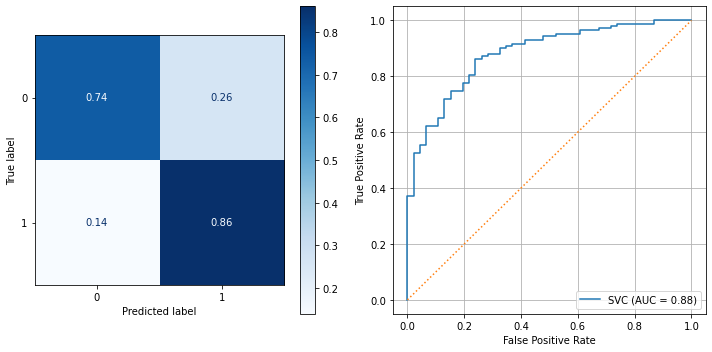

SVC(C=1, kernel='linear')

In [31]:
# tic = time() #timing!
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,X_train_sel,y_train_sm,X_test_sel,y_test)

In [32]:
## save to dict
# selected_features['variance'] = keep_features

### FM2: Using Correlation to identify & remove highly-correlated features

In [33]:
def get_list_of_corrs(df,drop=[],
                      cutoff=0.75,only_above_cutoff=False,
                     sort_by_col=False):
    """Get dataframe of correlated features, with the option to only show the
    features with correlations > cutoff"""
    ## Claculate correlation and convert to 3-column table.
    corr_df = df.drop(drop,axis=1).corr().unstack().reset_index()
    
    ## Remove self-correlations
    corr_df = corr_df.loc[ corr_df['level_0']!=corr_df['level_1']]
    
    ## Make one column with unique names and drop duplicate pairs of cols
    corr_df['columns'] = corr_df.apply(
        lambda row: '_'.join(set(row[['level_0','level_1']] )), axis=1)
    corr_df.drop_duplicates(subset=['columns'],inplace=True)
    
    ## Rename Columns
    corr_df.rename({0:'r','level_0':'Column1',
               'level_1':'Column2'},axis=1,inplace=True)     

    ## Check if above cutoff 
    corr_df['above_cutoff'] = corr_df['r'] > cutoff
 
    ## Sort by col or by r-value
    if sort_by_col:
        corr_df = corr_df.sort_values( ['Column1','Column2'],ascending=True)
    else:
        corr_df =  corr_df.sort_values('r',ascending=False)
        
    
    ## Return only those above cutoff
    if only_above_cutoff:
        corr_df = corr_df[corr_df['above_cutoff']==True]
        
    ## Reset Index for Aesthetics
    corr_df.reset_index(drop=True)
    return corr_df.round(2)

In [34]:
# corr_df = get_list_of_corrs(df,cutoff=0.75, only_above_cutoff=True)
# corr_df.head()

> As with our Linear Regression, we would want to remove features that are highly multicollinear. (have correlation >0.7-0.8)

### FM3: Using Mutual Information


- [Wikipedia: Mutual Infromation](https://en.wikipedia.org/wiki/Mutual_information)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/7f3385f4d779f062696c134223b5683e754a6f1c"> 

- Mutual Information represents how much we can learn about the target from our features. 
    - The higher the value for mi the more information a feature contains about the target.
    - We want to keep features with the highest mutual information with the target.
    
    
- How many features to keep is somewhat arbitrary.
    - Can use `SelectKBest` to select top `K` m.i. features 
    - Can use `SelectPercentile` to select top %

In [35]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [36]:
mi = mutual_info_classif(X_train_sm, y_train_sm)
mi[:5]

array([0.01518963, 0.1060601 , 0.09263309, 0.09404456, 0.08840444])

In [37]:
## Make a series so we can see which features
mi_scores = pd.Series(mi,index=X_train_sm.columns).sort_values(ascending=False)
mi_scores = mi_scores.to_frame('MI')
mi_scores

MI
tqwt_medianValue_dec_25    0.17
tqwt_skewnessValue_dec_13  0.16
tqwt_entropy_log_dec_35    0.16
tqwt_TKEO_mean_dec_12      0.15
tqwt_TKEO_mean_dec_16      0.15
...                         ...
tqwt_skewnessValue_dec_31  0.00
det_entropy_shannon_6_coef 0.00
det_TKEO_mean_8_coef       0.00
det_entropy_log_8_coef     0.00
det_TKEO_mean_7_coef       0.00

[753 rows x 1 columns]

> Must choose to select top # or percentile of features to keep

In [38]:
k = 200
top_k_selector = SelectKBest(mutual_info_classif,k=k).fit(X_train_sm,y_train_sm)
top_k_columns = X_train_sm.columns[top_k_selector.get_support()]
top_k_columns

Index(['DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'rapJitter',
       'ppq5Jitter', 'minIntensity', 'maxIntensity', 'meanIntensity', 'f1',
       ...
       'tqwt_skewnessValue_dec_22', 'tqwt_skewnessValue_dec_23',
       'tqwt_skewnessValue_dec_24', 'tqwt_skewnessValue_dec_25',
       'tqwt_skewnessValue_dec_26', 'tqwt_skewnessValue_dec_30',
       'tqwt_skewnessValue_dec_36', 'tqwt_kurtosisValue_dec_26',
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_36'],
      dtype='object', length=200)

In [39]:
X_train_sel = X_train_sm.loc[:,top_k_columns]
X_test_sel = X_test_df.loc[:,top_k_columns]
X_train_sel

DFA  RPDE  numPulses  numPeriodsPulses  rapJitter  ppq5Jitter  \
0   0.57  0.40       0.37              0.37       0.06        0.07   
1   0.24  0.53       0.34              0.34       0.02        0.03   
2   0.84  0.46       0.32              0.32       0.09        0.10   
3   0.57  0.72       0.37              0.37       0.08        0.10   
4   0.56  0.64       0.25              0.25       0.03        0.04   
..   ...   ...        ...               ...        ...         ...   
837 0.40  0.36       0.49              0.50       0.01        0.01   
838 0.76  0.36       0.44              0.44       0.02        0.03   
839 0.09  0.44       0.80              0.80       0.05        0.04   
840 0.31  0.38       0.55              0.55       0.00        0.01   
841 0.06  0.39       0.80              0.80       0.00        0.01   

     minIntensity  maxIntensity  meanIntensity   f1  VFER_mean  VFER_entropy  \
0            0.87          0.85           0.86 0.50       0.04          0.04   
1            0.84          0.84           0.84 0.67       0.02          0.02   
2            0.83          0.83           0.83 0.65       0.01          0.01   
3            0.54          0.64           0.61 0.78       0.01          0.01   
4            0.85          0.88           0.86 0.44       0.00          0.00   
..            ...           ...            ...  ...        ...           ...   
837          0.86          0.86           0.84 0.79       0.11          0.11   
838          0.72          0.71           0.71 0.25       0.05          0.05   
839          0.85          0.82           0.83 0.77       0.42          0.55   
840          0.87          0.86           0.86 0.58       0.21          0.20   
841          0.85          0.83           0.83 0.81       0.43          0.55   

     mean_MFCC_2nd_coef  mean_7th_delta_delta  std_Log_energy  \
0                  0.44                  0.20            0.03   
1                  0.31                  0.18            0.04   
2                  0.74                  0.22            0.04   
3                  0.46                  0.15            0.17   
4                  0.50                  0.32            0.05   
..                  ...                   ...             ...   
837                0.18                  0.24            0.03   
838                0.55                  0.34            0.04   
839                0.14                  0.26            0.02   
840                0.22                  0.23            0.04   
841                0.11                  0.28            0.02   

     std_MFCC_4th_coef  std_delta_log_energy  std_3rd_delta  std_4th_delta  \
0                 0.37                  0.04           0.13           0.24   
1                 0.36                  0.10           0.20           0.30   
2                 0.19                  0.10           0.12           0.18   
3                 0.35                  0.15           0.43           0.31   
4                 0.21                  0.08           0.27           0.19   
..                 ...                   ...            ...            ...   
837               0.23                  0.06           0.24           0.22   
838               0.19                  0.10           0.08           0.13   
839               0.43                  0.05           0.25           0.40   
840               0.23                  0.04           0.24           0.22   
841               0.46                  0.03           0.27           0.38   

     std_6th_delta  std_8th_delta  std_9th_delta  std_10th_delta  \
0             0.20           0.25           0.22            0.29   
1             0.25           0.31           0.32            0.34   
2             0.22           0.38           0.21            0.34   
3             0.50           0.59           0.59            0.78   
4             0.20           0.26           0.37            0.40   
..             ...            ...            ...             ...   
837      

[i] Training started at 05/18/21-13:21:27:
	Training time was 0.1024 seconds.

           Train  Test  Difference
accuracy   0.89  0.83        0.07 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.76      0.68        46
           1       0.92      0.85      0.88       143

    accuracy                           0.83       189
   macro avg       0.77      0.80      0.78       189
weighted avg       0.84      0.83      0.83       189



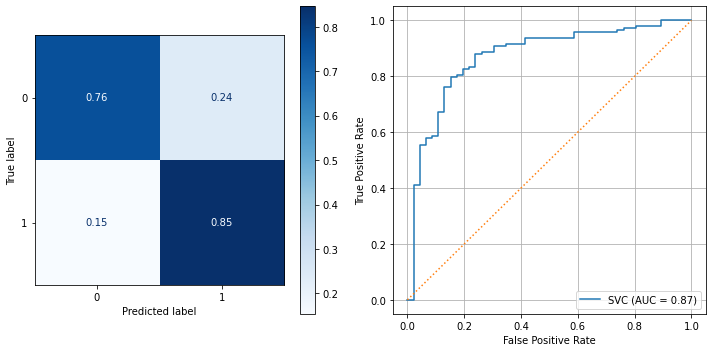

SVC(C=1, kernel='linear')

In [40]:
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,X_train_sel,y_train_sm,X_test_sel,y_test)

#### FM4: Univariate Models 

- While not demo'd in this notebook,an example univariate modeling approach would be to take all of the features of a house one at a time to make separate simple linear regression models. 
- Then, select the top K features that had the good performance (R-Squared).

## Wrapper Methods Applied

- Overall Wrapper Methods Process:
    - Use a specific classifier to select the optimal number of features. 
    - General approach is to create many recursive models where a feature is added or removed from the dataset and the performance is scored. 
    - Greedy search algorithms (will try all options)

___

- Example Wrapper Methods (used below):
    1. Stepwise Forward Selection 
    2. Stepwise Backward Selection/Recursive Feature Elimination. 
    
    3. Exhaustive Feature Selection

### WM1&2: Stepwise Forward/Backwards Selection with `mlxtend`'s `SequentialFeatureSelector`

- [mlxtend Sequential Feature Selector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)

> As of 0.24, it looks like scikit-learn has also added a SequentialFeatureSelector (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector

- To use SFS, must provide:
    1. Make an instance of the model you wish to optimize for (e.g. Random Forests, SVC)
    2. Choose a stopping criterion (e.g. select 10 features).
    3. Specify if want to step forward or backward. 
    4. Evaluation metric to use
    5. Cross validation

In [42]:
# svc_linear = SVC(kernel='linear',C=1)
sfs = SequentialFeatureSelector( SVC(kernel='linear',C=1), k_features=25,
                               forward=True, floating=True,
                                verbose=2, cv=2,
                                n_jobs=-1)
sfs.fit(X_train_sm,y_train_sm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 753 out of 753 | elapsed:    4.4s finished

[2021-05-18 13:21:32] Features: 1/25 -- score: 0.7090261282660333[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 729 out of 752 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 752 out of 752 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-05-18 13:21:34] Features: 2/25 -- score: 0.7434679334916865[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 737 out of 737 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2021-05-18 13:22:11] Features: 17/25 -- score: 0.8230403800475059[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 713 out of 736 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 736 out of 736 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers

SequentialFeatureSelector(cv=2, estimator=SVC(C=1, kernel='linear'),
                          floating=True, k_features=25, n_jobs=-1, verbose=2)

In [43]:
sfs.k_feature_idx_

(10,
 29,
 38,
 68,
 84,
 87,
 131,
 139,
 141,
 150,
 151,
 155,
 243,
 246,
 320,
 321,
 331,
 403,
 467,
 528,
 572,
 590,
 696,
 697,
 712)

In [44]:
selected_features = list(sfs.k_feature_names_)
selected_features

['ppq5Jitter',
 'b2',
 'GNE_SNR_SEO',
 'mean_delta_log_energy',
 'mean_1st_delta_delta',
 'mean_4th_delta_delta',
 'std_6th_delta_delta',
 'Ed_1_coef',
 'Ed_3_coef',
 'det_entropy_shannon_2_coef',
 'det_entropy_shannon_3_coef',
 'det_entropy_shannon_7_coef',
 'det_LT_entropy_shannon_4_coef',
 'det_LT_entropy_shannon_7_coef',
 'tqwt_energy_dec_1',
 'tqwt_energy_dec_2',
 'tqwt_energy_dec_12',
 'tqwt_entropy_log_dec_12',
 'tqwt_TKEO_std_dec_4',
 'tqwt_medianValue_dec_29',
 'tqwt_stdValue_dec_1',
 'tqwt_stdValue_dec_19',
 'tqwt_skewnessValue_dec_17',
 'tqwt_skewnessValue_dec_18',
 'tqwt_skewnessValue_dec_33']

In [45]:
X_train_sel = X_train_sm[selected_features]
X_test_sel = X_test_df[selected_features]
X_train_sel

ppq5Jitter   b2  GNE_SNR_SEO  mean_delta_log_energy  \
0          0.07 0.06         0.24                   0.53   
1          0.03 0.05         0.42                   0.53   
2          0.10 0.01         0.59                   0.54   
3          0.10 0.02         0.48                   0.47   
4          0.04 0.02         0.48                   0.55   
..          ...  ...          ...                    ...   
837        0.01 0.05         0.63                   0.50   
838        0.03 0.07         0.33                   0.54   
839        0.04 0.16         0.36                   0.52   
840        0.01 0.02         0.60                   0.55   
841        0.01 0.13         0.46                   0.52   

     mean_1st_delta_delta  mean_4th_delta_delta  std_6th_delta_delta  \
0                    0.51                  0.41                 0.20   
1                    0.60                  0.32                 0.31   
2                    0.49                  0.43                 0.27   
3                    0.47                  0.38                 0.52   
4                    0.56                  0.32                 0.22   
..                    ...                   ...                  ...   
837                  0.52                  0.39                 0.29   
838                  0.48                  0.44                 0.10   
839                  0.46                  0.41                 0.29   
840                  0.54                  0.31                 0.11   
841                  0.46                  0.40                 0.26   

     Ed_1_coef  Ed_3_coef  det_entropy_shannon_2_coef  \
0         0.00       0.00                        1.00   
1         0.00       0.00                        1.00   
2         0.00       0.00                        1.00   
3         0.00       0.00                        1.00   
4         0.00       0.00                        1.00   
..         ...        ...                         ...   
837       0.00       0.00                        1.00   
838       0.00       0.00                        1.00   
839       0.00       0.00                        1.00   
840       0.00       0.00                        1.00   
841       0.00       0.00                        1.00   

     det_entropy_shannon_3_coef  det_entropy_shannon_7_coef  \
0                          1.00                        1.00   
1                          1.00                        1.00   
2                          1.00                        0.99   
3                          1.00                        1.00   
4                          1.00                        1.00   
..                          ...                         ...   
837                        1.00                        1.00   
838                        1.00                        1.00   
839                        1.00                        1.00   
840                        1.00                        1.00   
841                        1.00                        1.00   

     det_LT_entropy_shannon_4_coef  det_LT_entropy_shannon_7_coef  \
0                             0.90                           0.99   
1                             0.90                           0.99   
2                             0.94                           1.00   
3                             0.90                           0.99   
4                             0.90                           0.99   
..                             ...                            ...   
837                           0.90                           0.99   
838                           0.91                           0.99   
839                           0.90                           0.99   
840                           0.90                           0.99   
841                           0.90                           0.99   

     tqwt_energy_dec_1  tqwt_energy_dec_2  tqwt_energy_dec_12  \
0                 0.01               0.00                0.00   
1                 

[i] Training started at 05/18/21-13:22:41:
	Training time was 0.0258 seconds.

           Train  Test  Difference
accuracy   0.82  0.74        0.08 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.76      0.59        46
           1       0.91      0.73      0.81       143

    accuracy                           0.74       189
   macro avg       0.69      0.75      0.70       189
weighted avg       0.80      0.74      0.76       189



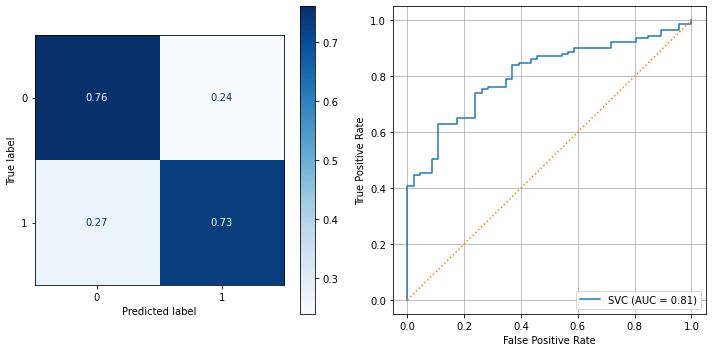

SVC(C=1, kernel='linear')

In [46]:
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,X_train_sel,y_train_sm,X_test_sel,y_test)

### WM3: Exhaustive Feature Selection

In [47]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

## Using Embedded Methods

- Overall Embedded Methods Process:
    1. Train a machine learning model (Feature selection performed during the model's training. )
    2. Derive feature importance from the model
    3. Remove non-important features.
___

- Example Embedded Methods (used below):
    1. Regression Coefficients 
    2. Tree importance 
    3. LASSO/L1-Regularization


### LogisticRegression Coefficients

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

[i] Training started at 05/18/21-13:22:41:
	Training time was 0.1101 seconds.

           Train  Test  Difference
accuracy   1.00  0.79        0.21 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.63      0.60        46
           1       0.88      0.85      0.86       143

    accuracy                           0.79       189
   macro avg       0.72      0.74      0.73       189
weighted avg       0.80      0.79      0.80       189



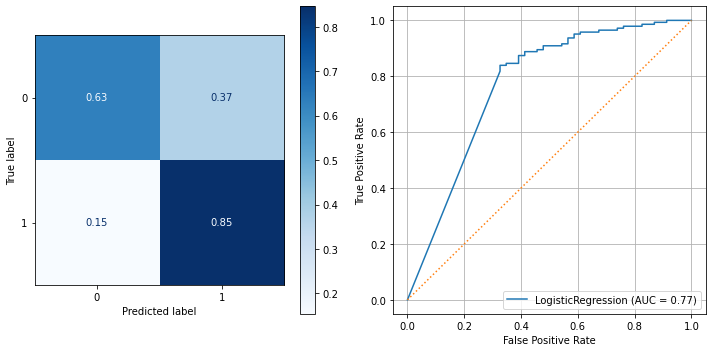

LogisticRegression(C=1000000000000.0)

In [49]:
log_reg = LogisticRegression(C=1e12)
pf.fit_and_time_model(log_reg,*train_test_list)

In [50]:
selector = SelectFromModel(log_reg).fit(X_train_sm,y_train_sm)
selector

SelectFromModel(estimator=LogisticRegression(C=1000000000000.0))

In [51]:
logreg_features = selector.get_support()
X_train_sm.columns[logreg_features]

Index(['PPE', 'RPDE', 'numPulses', 'numPeriodsPulses', 'stdDevPeriodPulses',
       'locPctJitter', 'locAbsJitter', 'ppq5Jitter', 'apq11Shimmer',
       'minIntensity',
       ...
       'tqwt_kurtosisValue_dec_8', 'tqwt_kurtosisValue_dec_12',
       'tqwt_kurtosisValue_dec_17', 'tqwt_kurtosisValue_dec_22',
       'tqwt_kurtosisValue_dec_26', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_31', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_35', 'gender_1'],
      dtype='object', length=275)

In [52]:
coeffs = pd.Series(selector.estimator_.coef_.flatten(),
                   index=X_train_sm.columns)
coeffs[logreg_features]

PPE                          -49.34
RPDE                          68.21
numPulses                    -24.99
numPeriodsPulses             -25.48
stdDevPeriodPulses            93.65
                              ...  
tqwt_kurtosisValue_dec_29     63.78
tqwt_kurtosisValue_dec_31   -110.70
tqwt_kurtosisValue_dec_33    133.81
tqwt_kurtosisValue_dec_35    -28.44
gender_1                      47.01
Length: 275, dtype: float64

In [53]:
X_train_sel = X_train_sm.loc[:,logreg_features]
X_test_sel = X_test_df.loc[:,logreg_features]
X_train_sel

PPE  RPDE  numPulses  numPeriodsPulses  stdDevPeriodPulses  locPctJitter  \
0   0.91  0.40       0.37              0.37                0.01          0.08   
1   0.92  0.53       0.34              0.34                0.01          0.04   
2   0.14  0.46       0.32              0.32                0.64          0.13   
3   0.94  0.72       0.37              0.37                0.03          0.11   
4   0.85  0.64       0.25              0.25                0.03          0.05   
..   ...   ...        ...               ...                 ...           ...   
837 0.94  0.36       0.49              0.50                0.02          0.04   
838 0.82  0.36       0.44              0.44                0.01          0.03   
839 0.82  0.44       0.80              0.80                0.14          0.06   
840 0.89  0.38       0.55              0.55                0.03          0.02   
841 0.89  0.39       0.80              0.80                0.02          0.01   

     locAbsJitter  ppq5Jitter  apq11Shimmer  minIntensity  maxIntensity  \
0            0.05        0.07          0.17          0.87          0.85   
1            0.03        0.03          0.18          0.84          0.84   
2            0.10        0.10          0.12          0.83          0.83   
3            0.07        0.10          0.35          0.54          0.64   
4            0.05        0.04          0.09          0.85          0.88   
..            ...         ...           ...           ...           ...   
837          0.02        0.01          0.07          0.86          0.86   
838          0.02        0.03          0.14          0.72          0.71   
839          0.02        0.04          0.15          0.85          0.82   
840          0.01        0.01          0.04          0.87          0.86   
841          0.00        0.01          0.13          0.85          0.83   

     meanIntensity   f1   f2   f4   b1   b3   b4  GQ_prc5_95  \
0             0.86 0.50 0.36 0.53 0.08 0.01 0.02        1.00   
1             0.84 0.67 0.46 0.40 0.01 0.06 0.43        1.00   
2             0.83 0.65 0.42 0.56 0.09 0.01 0.02        1.00   
3             0.61 0.78 0.57 0.77 0.07 0.06 0.08        0.64   
4             0.86 0.44 0.36 0.32 0.03 0.02 0.58        0.96   
..             ...  ...  ...  ...  ...  ...  ...         ...   
837           0.84 0.79 0.67 0.67 0.09 0.07 0.14        1.00   
838           0.71 0.25 0.39 0.25 0.10 0.21 0.01        0.82   
839           0.83 0.77 0.41 0.08 0.09 0.05 0.04        0.87   
840           0.86 0.58 0.57 0.59 0.02 0.11 0.09        1.00   
841           0.83 0.81 0.52 0.19 0.08 0.10 0.07        1.00   

     GQ_std_cycle_open  GQ_std_cycle_closed  GNE_std  GNE_SNR_TKEO  \
0                 0.13                 0.00     0.04          0.10   
1                 0.02                 0.00     0.08          0.14   
2                 0.05                 0.00     0.13          0.20   
3                 0.30                 0.64     0.11          0.08   
4                 0.33                 0.07     0.08          0.09   
..                 ...                  ...      ...           ...   
837               0.03                 0.00     0.15          0.11   
838               0.10                 0.12     0.12          0.10   
839               0.11                 0.18     0.36          0.09   
840               0.04                 0.00     0.13          0.18   
841               0.06                 0.00     0.29          0.08   

     GNE_SNR_SEO  GNE_NSR_TKEO  VFER_SNR_TKEO  VFER_SNR_SEO  VFER_NSR_SEO  \
0           0.24          0.26           0.03          0.05          0.32   
1           0.42          0.31           0.02          0.01          0.15   
2           0.59          0.36           0.05          0.04          0.30   
3           0.48          0.24           0.07          0.06          0.30   
4           0.48          0.21           0.01          0.03          0.26   
..           ...           ...            ...           ...

[i] Training started at 05/18/21-13:22:43:
	Training time was 0.1424 seconds.

           Train  Test  Difference
accuracy   0.98  0.79        0.18 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.70      0.62        46
           1       0.89      0.83      0.86       143

    accuracy                           0.79       189
   macro avg       0.73      0.76      0.74       189
weighted avg       0.81      0.79      0.80       189



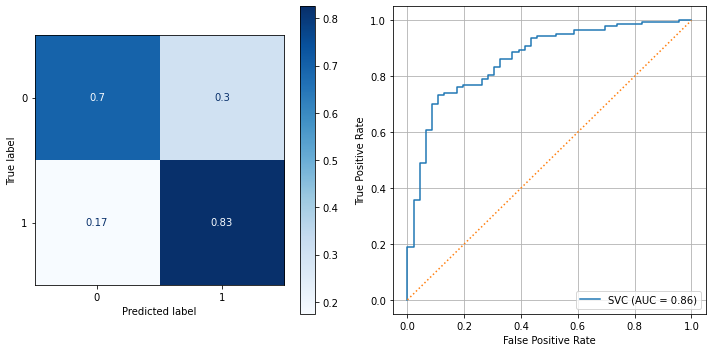

SVC(C=1, kernel='linear')

In [54]:
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,X_train_sel,y_train_sm,X_test_sel,y_test)

### LogisticRegression Coefficients  With Lasso/L1 Reg

[i] Training started at 05/18/21-13:22:44:
	Training time was 0.1682 seconds.

           Train  Test  Difference
accuracy   0.86  0.80        0.06 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        46
           1       0.91      0.83      0.86       143

    accuracy                           0.80       189
   macro avg       0.74      0.78      0.76       189
weighted avg       0.83      0.80      0.81       189



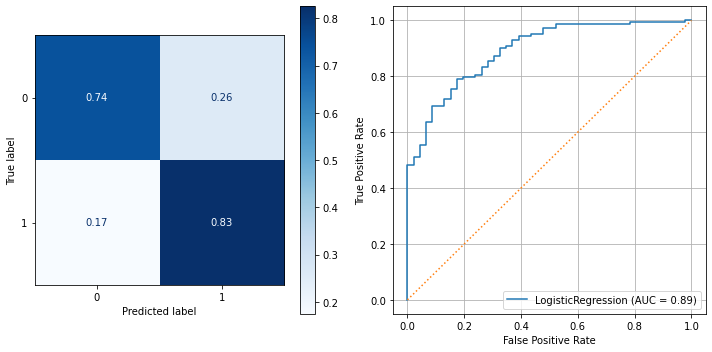

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

In [55]:
l1_reg = LogisticRegression(C=0.5,penalty='l1',solver='liblinear')
pf.fit_and_time_model(l1_reg,*train_test_list)

In [56]:
selector = SelectFromModel(l1_reg)
selector.fit(X_train_sm,y_train_sm)
lasso_features = selector.get_support()
lasso_features.sum()

48

In [57]:
X_train_sm.columns[lasso_features]

Index(['DFA', 'RPDE', 'stdDevPeriodPulses', 'f1', 'b4', 'mean_MFCC_1st_coef',
       'mean_MFCC_6th_coef', 'mean_MFCC_7th_coef', 'mean_MFCC_9th_coef',
       'mean_MFCC_10th_coef', 'mean_2nd_delta', 'mean_3rd_delta',
       'mean_3rd_delta_delta', 'mean_11th_delta_delta', 'std_MFCC_2nd_coef',
       'std_8th_delta', 'std_delta_delta_log_energy', 'std_6th_delta_delta',
       'std_7th_delta_delta', 'std_9th_delta_delta', 'Ed2_4_coef',
       'det_LT_entropy_shannon_4_coef', 'det_LT_entropy_log_8_coef',
       'tqwt_energy_dec_18', 'tqwt_energy_dec_19', 'tqwt_energy_dec_25',
       'tqwt_entropy_shannon_dec_25', 'tqwt_entropy_log_dec_25',
       'tqwt_entropy_log_dec_26', 'tqwt_entropy_log_dec_28',
       'tqwt_entropy_log_dec_33', 'tqwt_entropy_log_dec_34',
       'tqwt_medianValue_dec_5', 'tqwt_meanValue_dec_5',
       'tqwt_meanValue_dec_22', 'tqwt_minValue_dec_2', 'tqwt_minValue_dec_11',
       'tqwt_minValue_dec_17', 'tqwt_maxValue_dec_7', 'tqwt_maxValue_dec_11',
       'tqwt_maxVal

In [58]:
X_train_sel = X_train_sm.loc[:,lasso_features]
X_test_sel = X_test_df.loc[:,lasso_features]
X_train_sel

DFA  RPDE  stdDevPeriodPulses   f1   b4  mean_MFCC_1st_coef  \
0   0.57  0.40                0.01 0.50 0.02                0.57   
1   0.24  0.53                0.01 0.67 0.43                0.47   
2   0.84  0.46                0.64 0.65 0.02                0.26   
3   0.57  0.72                0.03 0.78 0.08                0.40   
4   0.56  0.64                0.03 0.44 0.58                0.68   
..   ...   ...                 ...  ...  ...                 ...   
837 0.40  0.36                0.02 0.79 0.14                0.55   
838 0.76  0.36                0.01 0.25 0.01                0.59   
839 0.09  0.44                0.14 0.77 0.04                0.50   
840 0.31  0.38                0.03 0.58 0.09                0.48   
841 0.06  0.39                0.02 0.81 0.07                0.47   

     mean_MFCC_6th_coef  mean_MFCC_7th_coef  mean_MFCC_9th_coef  \
0                  0.50                0.52                0.99   
1                  0.56                0.59                0.71   
2                  0.61                0.50                0.69   
3                  0.62                0.66                0.61   
4                  0.62                0.28                0.89   
..                  ...                 ...                 ...   
837                0.49                0.53                0.23   
838                0.61                0.28                0.44   
839                0.65                0.21                0.42   
840                0.45                0.34                0.15   
841                0.62                0.28                0.33   

     mean_MFCC_10th_coef  mean_2nd_delta  mean_3rd_delta  \
0                   0.34            0.53            0.48   
1                   0.55            0.40            0.37   
2                   0.02            0.47            0.41   
3                   0.11            0.51            0.56   
4                   0.10            0.73            0.40   
..                   ...             ...             ...   
837                 0.54            0.39            0.37   
838                 0.17            0.36            0.46   
839                 0.28            0.06            0.47   
840                 0.47            0.73            0.79   
841                 0.29            0.12            0.40   

     mean_3rd_delta_delta  mean_11th_delta_delta  std_MFCC_2nd_coef  \
0                    0.53                   0.46               0.23   
1                    0.53                   0.62               0.19   
2                    0.53                   0.55               0.08   
3                    0.93                   0.65               0.55   
4                    0.43                   0.64               0.56   
..                    ...                    ...                ...   
837                  0.46                   0.53               0.32   
838                  0.57                   0.60               0.10   
839                  0.56                   0.50               0.58   
840                  0.61                   0.45               0.69   
841                  0.61                   0.57               0.57   

     std_8th_delta  std_delta_delta_log_energy  std_6th_delta_delta  \
0             0.25                        0.07                 0.20   
1             0.31                        0.25                 0.31   
2             0.38                        0.16                 0.27   
3             0.59                        0.24                 0.52   
4             0.26                        0.15                 0.22   
..             ...                         ...                  ...   
837           0.41                        0.10                 0.29   
838           0.16                        0.11                 0.10   
839           0.28                        0.08                 0.29   
840           0.32                        0.06                 0.11   
841           0.35          

[i] Training started at 05/18/21-13:22:45:
	Training time was 0.0283 seconds.

           Train  Test  Difference
accuracy   0.91  0.84        0.08 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.76      0.69        46
           1       0.92      0.86      0.89       143

    accuracy                           0.84       189
   macro avg       0.78      0.81      0.79       189
weighted avg       0.85      0.84      0.84       189



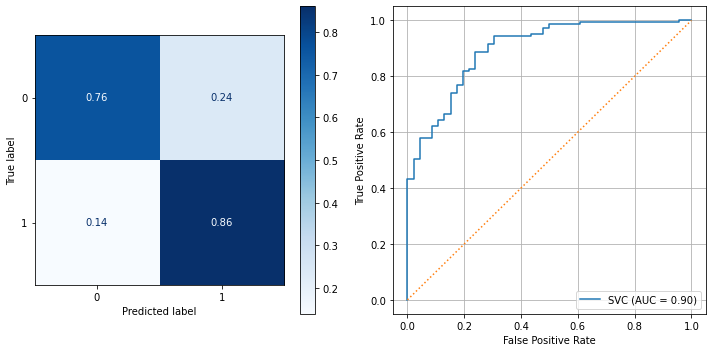

SVC(C=1, kernel='linear')

In [59]:
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,X_train_sel,y_train_sm,X_test_sel,y_test)

### Tree Importance

In [60]:
rf = RandomForestClassifier()
# pf.fit_and_time_model(rf,*train_test_list)
# importances = pf.get_importance(rf,X_train_df)
# importances.sort_values(ascending=False)

In [61]:
selector = SelectFromModel(rf).fit(X_train_sm,y_train_sm)
rf_features = selector.get_support()
rf_features.sum()

208

In [62]:
X_train_sel = X_train_sm.loc[:,rf_features]
X_test_sel = X_test_df.loc[:,rf_features]
X_train_sel

DFA  numPulses  meanPeriodPulses  locPctJitter  locAbsJitter  \
0   0.57       0.37              0.37          0.08          0.05   
1   0.24       0.34              0.41          0.04          0.03   
2   0.84       0.32              0.45          0.13          0.10   
3   0.57       0.37              0.36          0.11          0.07   
4   0.56       0.25              0.65          0.05          0.05   
..   ...        ...               ...           ...           ...   
837 0.40       0.49              0.22          0.04          0.02   
838 0.76       0.44              0.27          0.03          0.02   
839 0.09       0.80              0.05          0.06          0.02   
840 0.31       0.55              0.18          0.02          0.01   
841 0.06       0.80              0.07          0.01          0.00   

     apq11Shimmer  meanNoiseToHarmHarmonicity  minIntensity  maxIntensity  \
0            0.17                        0.06          0.87          0.85   
1            0.18                        0.03          0.84          0.84   
2            0.12                        0.03          0.83          0.83   
3            0.35                        0.19          0.54          0.64   
4            0.09                        0.04          0.85          0.88   
..            ...                         ...           ...           ...   
837          0.07                        0.01          0.86          0.86   
838          0.14                        0.03          0.72          0.71   
839          0.15                        0.09          0.85          0.82   
840          0.04                        0.00          0.87          0.86   
841          0.13                        0.03          0.85          0.83   

      f3   f4   b1  GNE_NSR_TKEO  GNE_NSR_SEO  IMF_NSR_SEO  \
0   0.74 0.53 0.08          0.26         0.52         0.23   
1   0.67 0.40 0.01          0.31         0.57         0.24   
2   0.82 0.56 0.09          0.36         0.51         0.30   
3   0.80 0.77 0.07          0.24         0.48         0.20   
4   0.66 0.32 0.03          0.21         0.51         0.40   
..   ...  ...  ...           ...          ...          ...   
837 0.68 0.67 0.09          0.24         0.51         0.28   
838 0.20 0.25 0.10          0.27         0.54         0.51   
839 0.13 0.08 0.09          0.28         0.58         0.06   
840 0.44 0.59 0.02          0.33         0.43         0.25   
841 0.25 0.19 0.08          0.26         0.59         0.07   

     mean_MFCC_2nd_coef  mean_MFCC_3rd_coef  mean_MFCC_5th_coef  \
0                  0.44                0.64                0.30   
1                  0.31                0.53                0.34   
2                  0.74                0.67                0.53   
3                  0.46                0.66                0.60   
4                  0.50                0.68                0.46   
..                  ...                 ...                 ...   
837                0.18                0.36                0.46   
838                0.55                0.32                0.56   
839                0.14                0.03                0.54   
840                0.22                0.47                0.33   
841                0.11                0.06                0.50   

     mean_MFCC_6th_coef  mean_MFCC_7th_coef  mean_MFCC_10th_coef  \
0                  0.50                0.52                 0.34   
1                  0.56                0.59                 0.55   
2                  0.61                0.50                 0.02   
3                  0.62                0.66                 0.11   
4                  0.62                0.28                 0.10   
..                  ...                 ...                  ...   
837                0.49                0.53                 0.54   
838                0.61                0.28                 0.17   
839                0.65                0.21                 0.28   
840                0.

[i] Training started at 05/18/21-13:22:47:
	Training time was 0.1226 seconds.

           Train  Test  Difference
accuracy   0.92  0.79        0.13 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.74      0.63        46
           1       0.91      0.80      0.85       143

    accuracy                           0.79       189
   macro avg       0.73      0.77      0.74       189
weighted avg       0.82      0.79      0.80       189



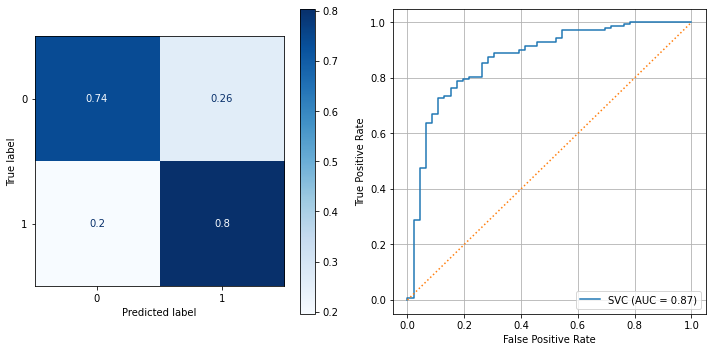

SVC(C=1, kernel='linear')

In [63]:
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,X_train_sel,y_train_sm,X_test_sel,y_test)

# ⭐️**Cross Validation**⭐️

#### Cross Validation Workflow: 

1. Train/Test split
2. Create a model. 
3. Apply Cross Validation with the training data (`GridsearchCV`,`cross_validate`,`cross_val_score`,`cross_val_predict`) to asses your model/hyperparameter choices.

4. Evaluate Cross validation scores
    - If not happy with the scores:
        - Try different model/hyperparameters.
    - If happy with scores/performance:
        - Train an **individual** model (not-cv) (or take gridsearch's `.best_estimator_` on the **training data** and **evaluate with the test data.**



5. If individual model performs well on test data (isn't overfit) **and you are planning to deploy the model:** 
    - You would **re-train the model** on the **entire combined data set** (X =X_train+X_test, y=y_train+y_test) before pickling/saving the model.
    
    
>- ***Note: step 5 is intended for deploying models and is not required.***

## 3 Different Ways of Cross-Validating

In [64]:
from sklearn.model_selection import cross_validate,cross_val_score,cross_val_predict

- Cross validation **functions** from sklearn.model_selection:
    - `cross_validate`: 
        - returns dict of K-fold  scores for the training data, including the training times.
    - `cross_val_score`:
        - returns the K-fold validation scores for the K-fold's test-splits
        
    - `cross_val_predict`:
        - returns predictions from the cross validated model. 

In [65]:
X_train_final = X_train_sm.loc[:,keep_features]
X_test_final = X_test_df.loc[:,keep_features]
display(X_train_final.head(),X_test_final.head())

PPE  DFA  RPDE  numPulses  numPeriodsPulses  meanPeriodPulses  \
0 0.91 0.57  0.40       0.37              0.37              0.37   
1 0.92 0.24  0.53       0.34              0.34              0.41   
2 0.14 0.84  0.46       0.32              0.32              0.45   
3 0.94 0.57  0.72       0.37              0.37              0.36   
4 0.85 0.56  0.64       0.25              0.25              0.65   

   stdDevPeriodPulses  locShimmer  locDbShimmer  apq3Shimmer  apq5Shimmer  \
0                0.01        0.31          0.32         0.34         0.23   
1                0.01        0.21          0.22         0.22         0.14   
2                0.64        0.19          0.20         0.21         0.13   
3                0.03        0.54          0.57         0.59         0.44   
4                0.03        0.09          0.10         0.08         0.07   

   apq11Shimmer  ddaShimmer  meanAutoCorrHarmonicity  \
0          0.17        0.34                     0.91   
1          0.18        0.22                     0.95   
2          0.12        0.21                     0.94   
3          0.35        0.59                     0.69   
4          0.09        0.08                     0.94   

   meanNoiseToHarmHarmonicity  meanHarmToNoiseHarmonicity  minIntensity  \
0                        0.06                        0.45          0.87   
1                        0.03                        0.49          0.84   
2                        0.03                        0.48          0.83   
3                        0.19                        0.23          0.54   
4                        0.04                        0.66          0.85   

   maxIntensity  meanIntensity   f1   f2   f3   f4   b2   b3   b4  GQ_prc5_95  \
0          0.85           0.86 0.50 0.36 0.74 0.53 0.06 0.01 0.02        1.00   
1          0.84           0.84 0.67 0.46 0.67 0.40 0.05 0.06 0.43        1.00   
2          0.83           0.83 0.65 0.42 0.82 0.56 0.01 0.01 0.02        1.00   
3          0.64           0.61 0.78 0.57 0.80 0.77 0.02 0.06 0.08        0.64   
4          0.88           0.86 0.44 0.36 0.66 0.32 0.02 0.02 0.58        0.96   

   GQ_std_cycle_open  GQ_std_cycle_closed  GNE_SNR_SEO  GNE_NSR_SEO  \
0               0.13                 0.00         0.24         0.52   
1               0.02                 0.00         0.42         0.57   
2               0.05                 0.00         0.59         0.51   
3               0.30                 0.64         0.48         0.48   
4               0.33                 0.07         0.48         0.51   

   VFER_SNR_TKEO  VFER_NSR_TKEO  VFER_NSR_SEO  IMF_SNR_TKEO  IMF_SNR_entropy  \
0           0.03           0.54          0.32          0.05             0.08   
1           0.02           0.43          0.15          0.04             0.03   
2           0.05           0.60          0.30          0.06             0.23   
3           0.07           0.60          0.30          0.04             0.06   
4           0.01           0.55          0.26          0.15             0.19   

   IMF_NSR_SEO  IMF_NSR_TKEO  IMF_NSR_entropy  mean_Log_energy  \
0         0.23          0.10             0.33             0.83   
1         0.24          0.14             0.35             0.78   
2         0.30          0.05             0.36             0.74   
3         0.20          0.12             0.27             0.47   
4         0.40          0.06             0.46             0.55   

   mean_MFCC_0th_coef  mean_MFCC_1st_coef  mean_MFCC_2nd_coef  \
0                0.69                0.57                0.44   
1                0.76                0.47                0.31   
2                0.70                0.26                0.74   
3                0.54                0.40                0.46   
4                0.44                0.68                0.50   

   mean_MFCC_3rd_coef  mean_MFCC_4th_coef  mean_MFCC_5th_coef  \
0                0.64                0.55                0.30   
1                0.53         

PPE  DFA  RPDE  numPulses  numPeriodsPulses  meanPeriodPulses  \
642 0.60 0.56  0.85       0.09              0.08              0.64   
645 0.86 0.72  0.43       0.21              0.21              0.80   
88  0.93 0.33  0.18       0.43              0.43              0.28   
491 0.87 0.52  0.29       0.32              0.33              0.44   
616 0.89 0.55  0.22       0.47              0.47              0.24   

     stdDevPeriodPulses  locShimmer  locDbShimmer  apq3Shimmer  apq5Shimmer  \
642                0.08        0.59          0.61         0.53         0.42   
645                0.03        0.20          0.21         0.22         0.14   
88                 0.01        0.05          0.05         0.06         0.03   
491                0.01        0.16          0.16         0.18         0.12   
616                0.01        0.17          0.18         0.18         0.13   

     apq11Shimmer  ddaShimmer  meanAutoCorrHarmonicity  \
642         -0.02        0.53                     0.04   
645          0.16        0.22                     0.96   
88           0.03        0.06                     0.99   
491          0.08        0.18                     0.96   
616          0.12        0.18                     0.98   

     meanNoiseToHarmHarmonicity  meanHarmToNoiseHarmonicity  minIntensity  \
642                        0.95                        0.01          0.55   
645                        0.02                        0.58          0.82   
88                         0.00                        0.78          0.89   
491                        0.02                        0.53          0.88   
616                        0.01                        0.62          0.80   

     maxIntensity  meanIntensity   f1   f2   f3   f4   b2   b3    b4  \
642          0.58           0.56 0.31 0.33 0.62 0.45 0.02 0.01 -0.00   
645          0.86           0.85 0.18 0.29 0.47 0.58 0.07 0.07  0.03   
88           0.87           0.88 0.70 0.42 0.75 0.67 0.03 0.04  0.04   
491          0.84           0.86 0.46 0.34 0.66 0.90 0.04 0.03  0.01   
616          0.76           0.78 0.41 0.29 0.40 0.51 0.03 0.19  0.09   

     GQ_prc5_95  GQ_std_cycle_open  GQ_std_cycle_closed  GNE_SNR_SEO  \
642        0.64               0.50                 0.83        -0.00   
645        0.74               0.11                 0.07         0.51   
88         1.00               0.01                 0.00         0.34   
491        0.91               0.03                 0.03         0.57   
616        1.00               0.06                 0.00         0.46   

     GNE_NSR_SEO  VFER_SNR_TKEO  VFER_NSR_TKEO  VFER_NSR_SEO  IMF_SNR_TKEO  \
642         0.37           0.01           0.29          0.18          0.02   
645         0.53           0.12           0.54          0.20          0.20   
88          0.49           0.04           0.63          0.34          0.06   
491         0.44           0.04           0.56          0.37          0.05   
616         0.55           0.24           0.92          0.73          0.12   

     IMF_SNR_entropy  IMF_NSR_SEO  IMF_NSR_TKEO  IMF_NSR_entropy  \
642             0.07         0.22          0.08             0.30   
645             0.54         0.39          0.00             0.44   
88              0.03         0.30          0.21             0.43   
491             0.14         0.17          0.09             0.21   
616             0.07         0.59          0.10             0.68   

     mean_Log_energy  mean_MFCC_0th_coef  mean_MFCC_1st_coef  \
642             0.45                0.56                0.45   
645             0.85                0.58                0.43   
88              0.87                0.63                0.65   
491             0.80                0.71                0.43   
616             0.84                0.49                0.62   

     mean_MFCC_2nd_coef  mean_MFCC_3rd_coef  mean_MFCC_4th_coef  \
642                0.47                0.59                0.81   
645                0.72           

In [66]:
## make an instance of a model
clf = SVC(kernel='linear',C=1)

In [67]:
## cross_validate  returns scores and times
cv_results = cross_validate(clf,X_train_final,y_train_sm,scoring='recall')
cv_results

{'fit_time': array([0.15151954, 0.15530372, 0.14763904, 0.15035105, 0.15950179]),
 'score_time': array([0.03207827, 0.03365827, 0.03207207, 0.03213191, 0.03410411]),
 'test_score': array([0.81176471, 0.94047619, 0.83333333, 0.85714286, 0.82142857])}

In [68]:
## cross_val_score reutns scores
cv_score = cross_val_score(clf,X_train_final,y_train_sm,scoring='recall')
cv_score

array([0.81176471, 0.94047619, 0.83333333, 0.85714286, 0.82142857])

In [69]:
cv_score.mean()

0.852829131652661

In [70]:
## cross_val_predict returns predictions that can be used to validate
y_hat_train_cv = cross_val_predict(clf,X_train_final,y_train_sm)
print(metrics.classification_report(y_train_sm, y_hat_train_cv))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       421
           1       0.93      0.85      0.89       421

    accuracy                           0.89       842
   macro avg       0.90      0.89      0.89       842
weighted avg       0.90      0.89      0.89       842



[i] Training started at 05/18/21-13:22:52:
	Training time was 0.2249 seconds.

         Train  Test  Difference
recall   0.94  0.86        0.08 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        46
           1       0.91      0.86      0.88       143

    accuracy                           0.83       189
   macro avg       0.77      0.80      0.78       189
weighted avg       0.84      0.83      0.84       189



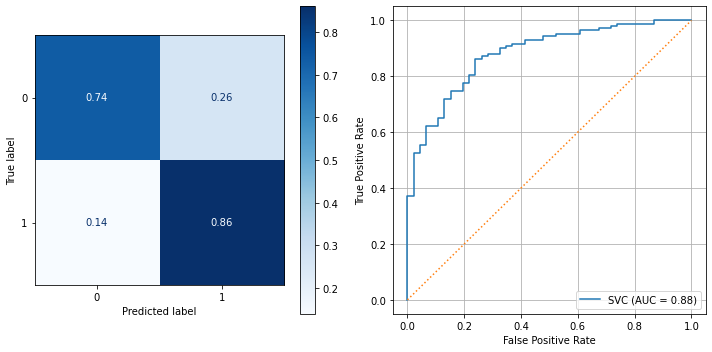

SVC(C=1, kernel='linear')

In [71]:
## If happy with results, train an individual model and evaluate with test data
clf = SVC(kernel='linear',C=1)
pf.fit_and_time_model(clf,X_train_final,y_train_sm,X_test_final, y_test,scoring='recall')

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       192
           1       0.96      0.99      0.98       564

    accuracy                           0.97       756
   macro avg       0.97      0.94      0.95       756
weighted avg       0.97      0.97      0.97       756



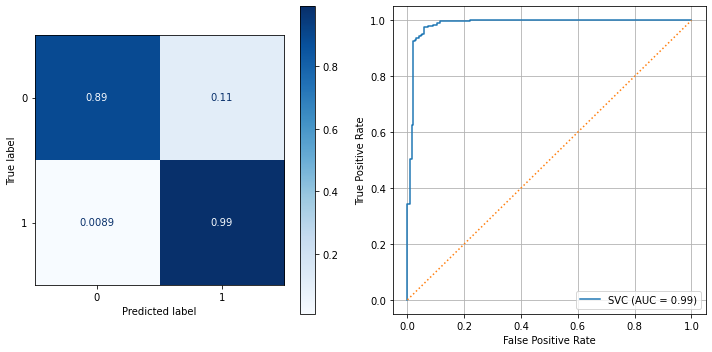

In [72]:
## If happy with train/test split results, can re-train model on entire dataset
X_tf = preprocessor.fit_transform(X)
svc_linear.fit(X_tf,y)
pf.evaluate_classification(svc_linear,X_tf,y)

# ⭐️**Saving Models**⭐️

- Guide on Saving Models: 
    - https://scikit-learn.org/stable/modules/model_persistence.html

### With `Pickle`

In [73]:
import pickle
pickle.dump(clf,open('best_model.pickle','wb'))
# s = pickle.dumps(clf)
# type(s)

In [74]:
loaded_pickle = pickle.load(open('best_model.pickle','rb'))
loaded_pickle

SVC(C=1, kernel='linear')

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        46
           1       0.91      0.86      0.88       143

    accuracy                           0.83       189
   macro avg       0.77      0.80      0.78       189
weighted avg       0.84      0.83      0.84       189



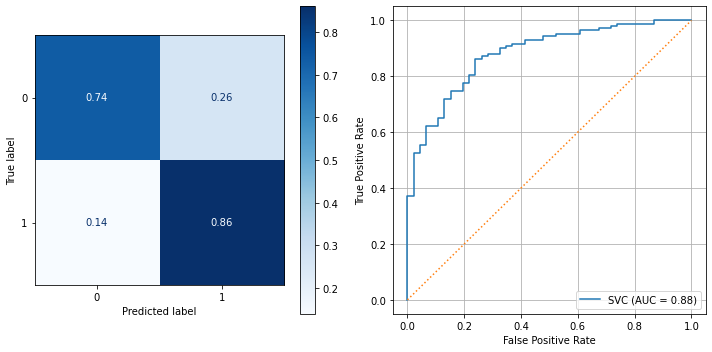

In [75]:
pf.evaluate_classification(loaded_pickle,X_test_final,y_test)

### With `joblib` (sklearn's preferred method)

In [76]:
import joblib
joblib.dump(clf, 'best_model.joblib') 

['best_model.joblib']

In [77]:
clf_jb = joblib.load('best_model.joblib')
clf_jb

SVC(C=1, kernel='linear')

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        46
           1       0.91      0.86      0.88       143

    accuracy                           0.83       189
   macro avg       0.77      0.80      0.78       189
weighted avg       0.84      0.83      0.84       189



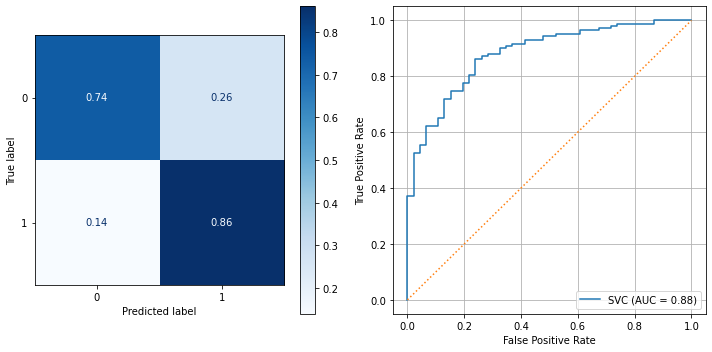

In [78]:
pf.evaluate_classification(clf_jb,X_test_final,y_test)

# Conclusions

- There are many different ways to select features for your models, each with advantages & disadvantages.
- Depending on the size of your dataset and the number of features will determine how much you need to worry about performing feature selection
